# 使用 DDPG 算法训练 Pendulum-v1 环境

**DDPG** 是 DPG 算法的一个重要改进，它通过引入 **经验回放 (Experience Replay)** 和 **目标网络 (Target Networks)** 解决了训练不稳定的问题，非常适合解决连续动作空间下的强化学习任务。它同样属于 Actor-Critic 框架：

1.  **Actor (策略网络)**: 学习在给定状态下应该采取什么动作。
2.  **Critic (价值网络)**: 评估在特定状态下采取某个动作的好坏（Q值）。
3.  **Target Networks**: Actor 和 Critic 网络各自拥有一套目标网络，用于在计算目标Q值时提供稳定的目标，并通过“软更新”缓慢地同步参数。

在本教程中，我们将使用 PyTorch 和 Gymnasium 来训练一个智能体，使其能够成功地将一个钟摆（Pendulum）竖立起来。

## 1. 导入必要的库

首先，我们导入所有必需的库，包括 `gym` 用于创建环境，`torch` 用于构建和训练神经网络，以及 `numpy` 和 `random` 用于数据处理。

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
np.bool8 = np.bool_ # 新版numpy把 np.bool8 指向 np.bool_
import random
from collections import deque
import copy

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2. 定义超参数和环境

在这一步，我们定义所有训练过程中需要用到的超参数。相比于 DPG，我们新增了 `tau` 用于目标网络的软更新。

- **`tau`**: 软更新系数。目标网络的参数将以 `(1-tau)` 的比例保留旧参数，并以 `tau` 的比例从主网络中更新，这使得目标网络的变化更加平滑。

In [2]:
# 定义一些超参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_name = "Pendulum-v1"
gamma = 0.99
lr = 0.001
batch_size = 64
max_episodes = 500
max_steps = 200
exploration_noise = 0.1
replay_buffer_size = 10000
tau = 0.005 # 目标网络软更新系数

# 创建环境
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

print(f"Device: {device}")
print(f"State Dimension: {state_dim}")
print(f"Action Dimension: {action_dim}")
print(f"Action Bound: {action_bound}")

Device: cuda
State Dimension: 3
Action Dimension: 1
Action Bound: 2.0


## 3. 定义 Actor-Critic 网络结构

网络结构与 DPG 保持一致。我们将为 Actor 和 Critic 分别创建两套网络：一套是主网络（用于训练和决策），另一套是目标网络（用于稳定学习过程）。

In [3]:
# 定义一个策略网络 (Actor)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x)) * action_bound
        return x

# 定义一个值函数网络 (Critic)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 4. 初始化网络、优化器和回放缓冲区

我们创建主网络和目标网络。目标网络的初始权重与主网络完全相同。然后为主网络定义优化器。

In [4]:
# 主网络
policy_net = PolicyNetwork(state_dim, action_dim).to(device)
value_net = ValueNetwork(state_dim, action_dim).to(device)

# 目标网络
policy_net_target = PolicyNetwork(state_dim, action_dim).to(device)
value_net_target = ValueNetwork(state_dim, action_dim).to(device)

# 初始化目标网络权重
policy_net_target.load_state_dict(policy_net.state_dict())
value_net_target.load_state_dict(value_net.state_dict())

# 优化器
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
value_optimizer = torch.optim.Adam(value_net.parameters(), lr=lr)

# 经验回放池
replay_buffer = deque(maxlen=replay_buffer_size)

## 5. 开始训练

DDPG 的训练流程与 DPG 类似，但有关键区别：

```
对于每个 episode:
  ...
  对于每个 time step t:
    ...
    (学习) 如果缓冲区数据足够：
       a. 从缓冲区随机采样一个 batch 的数据
       b. (关键) 计算目标Q值: y_i = r_i + gamma * Q_critic_target(s_{i+1}, a_{i+1}) (其中 a_{i+1} = mu_actor_target(s_{i+1}))
       c. 更新 Critic 主网络: 最小化 (y_i - Q_critic(s_i, a_i))^2
       d. 更新 Actor 主网络: 使用采样策略梯度最大化 Q_critic(s_i, mu_actor(s_i))
       e. (关键) 软更新目标网络: target_params = tau * main_params + (1-tau) * target_params
    ...
```

In [6]:
for i_episode in range(max_episodes):
    state, _ = env.reset()
    episode_reward = 0

    for t in range(max_steps):
        # --- 采样 ---
        state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device)
        action_tensor = policy_net(state_tensor)
        action = action_tensor.cpu().detach().numpy()
        noise = np.random.normal(0, exploration_noise, size=action_dim)
        action = np.clip(action + noise, -action_bound, action_bound)
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        episode_reward += reward

        # --- 学习 ---
        if len(replay_buffer) < batch_size:
            continue

        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.as_tensor(np.array(states), dtype=torch.float32, device=device)
        actions = torch.as_tensor(np.array(actions), dtype=torch.float32, device=device)
        rewards = torch.as_tensor(np.array(rewards), dtype=torch.float32, device=device).unsqueeze(-1)
        next_states = torch.as_tensor(np.array(next_states), dtype=torch.float32, device=device)
        dones = torch.as_tensor(np.array(dones), dtype=torch.float32, device=device).unsqueeze(-1)

        # --- 更新 Critic 网络 ---
        with torch.no_grad():
            # 使用目标网络计算下一个动作和下一个Q值
            next_actions = policy_net_target(next_states)
            next_q_values = value_net_target(next_states, next_actions)
            target_q_values = rewards + (1 - dones) * gamma * next_q_values

        current_q_values = value_net(states, actions)
        value_loss = F.mse_loss(current_q_values, target_q_values)

        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        # --- 更新 Actor 网络 ---
        policy_loss = -value_net(states, policy_net(states)).mean()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()
        
        # --- 软更新目标网络 ---
        for param, target_param in zip(value_net.parameters(), value_net_target.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        
        for param, target_param in zip(policy_net.parameters(), policy_net_target.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

        if done:
            break
    
    if (i_episode + 1) % 10 == 0:
        print(f"Episode: {i_episode+1}, Reward: {episode_reward:.2f}")

Episode: 10, Reward: -1389.95
Episode: 20, Reward: -755.39
Episode: 30, Reward: -339.02
Episode: 40, Reward: -128.58
Episode: 50, Reward: -125.39
Episode: 60, Reward: -247.05
Episode: 70, Reward: -238.77
Episode: 80, Reward: -238.34
Episode: 90, Reward: -120.52
Episode: 100, Reward: -226.88
Episode: 110, Reward: -118.85
Episode: 120, Reward: -119.55
Episode: 130, Reward: -245.45
Episode: 140, Reward: -118.59
Episode: 150, Reward: -117.33
Episode: 160, Reward: -249.02
Episode: 170, Reward: -2.08
Episode: 180, Reward: -123.55
Episode: 190, Reward: -116.83
Episode: 200, Reward: -117.11
Episode: 210, Reward: -117.83
Episode: 220, Reward: -118.58
Episode: 230, Reward: -241.28
Episode: 240, Reward: -1.22
Episode: 250, Reward: -378.72
Episode: 260, Reward: -370.25
Episode: 270, Reward: -240.98
Episode: 280, Reward: -116.54
Episode: 290, Reward: -126.39
Episode: 300, Reward: -121.86
Episode: 310, Reward: -2.45
Episode: 320, Reward: -245.27
Episode: 330, Reward: -131.25
Episode: 340, Reward: -2

## DPG与DDPG差距
### 取DPG的前500个episode
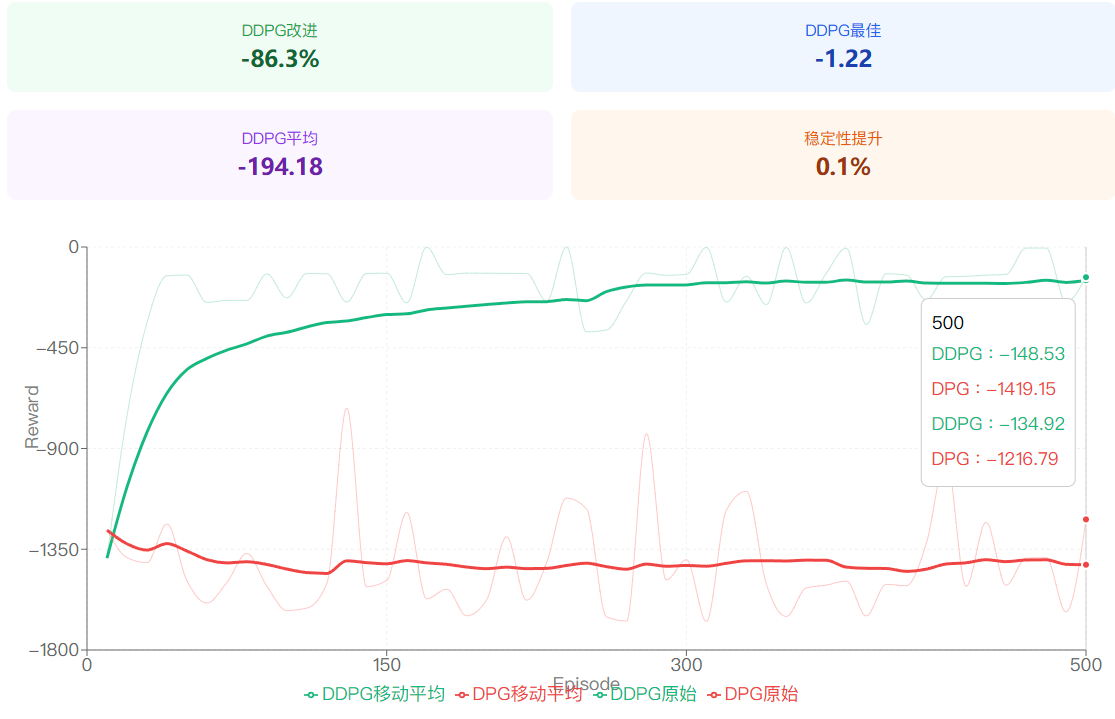
### DDPG训练成果
- 快速收敛：前40回合即达到良好性能
- 多次接近最优解（奖励接近0）
- 相对稳定的学习曲线
- 平均性能提升超过85%

**关键特点**
- Experience Replay提供稳定学习
- Target Network减少训练震荡
- Actor-Critic架构平衡探索与利用
- 连续动作空间处理能力强

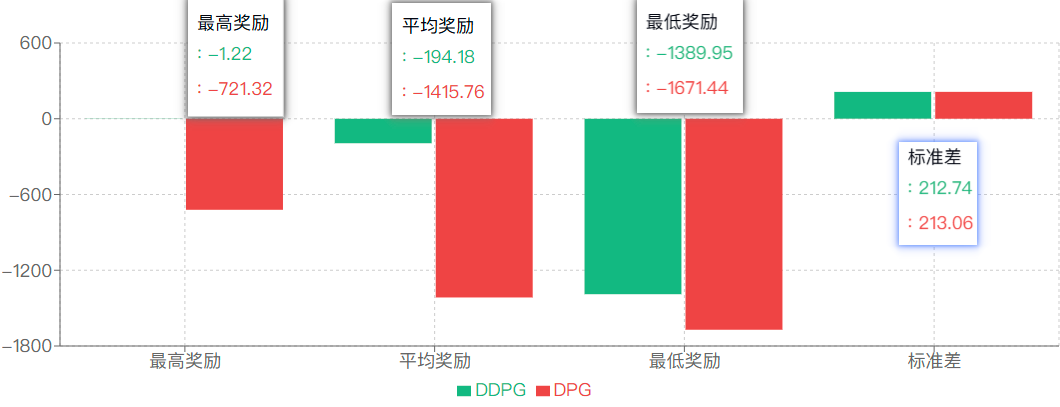

🎯 DDPG优势
- 平均奖励: -194.18 (提升 -86.3%)
- 最高奖励: -1.22 (接近最优)
- 学习速度: 快速收敛至稳定水平
- 稳定性: 相对稳定的性能表现

❌ DPG问题
- 平均奖励: -1415.76 (表现较差)
- 学习困难: 无明显收敛趋势
- 高方差: 训练不稳定
- 探索不足: 难以找到有效策略